## Algoritmo LSTM

In [ ]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import random

In [2]:
# Establecer una semilla aleatoria
seed_value = 24
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(48)

In [3]:
nombre_csv = 4160
de = pd.read_csv(f'Datos_entrenamiento2/{nombre_csv}_e.csv')
dp = pd.read_csv(f'Datos_prueba2/{nombre_csv}_p.csv')

In [26]:
dp

,Fecha,Hora,period eating,period other,period resting,period rumination,period eating_count,period other_count,period resting_count,period rumination_count,nivel_actividad,distancia,nivel_estres
0,2024-07-02,0,0.079,0.0,0.511,0.410,1.0,0.0,2.0,1.0,-0.249625,0.117183,0
1,2024-07-02,1,0.000,0.0,0.426,0.574,0.0,0.0,1.0,1.0,-0.297680,0.105690,0
2,2024-07-02,2,0.000,0.0,0.489,0.511,0.0,0.0,2.0,1.0,-0.287678,0.097722,0
3,2024-07-02,3,0.000,0.0,0.934,0.066,0.0,0.0,1.0,1.0,-0.217033,0.134944,0
4,2024-07-02,4,0.043,0.0,0.748,0.210,1.0,0.0,2.0,2.0,-0.228115,0.118325,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2024-11-22,19,0.000,0.0,0.354,0.646,0.0,0.0,1.0,2.0,-0.309110,0.052213,0
2516,2024-11-22,20,0.118,0.0,0.462,0.420,1.0,0.0,1.0,1.0,-0.240343,0.063239,0
2517,2024-11-22,21,0.354,0.0,0.207,0.439,1.0,0.0,2.0,3.0,-0.177580,0.076083,0
2518,2024-11-22,22,0.433,0.0,0.220,0.348,1.0,0.0,2.0,1.0,-0.141321,0.093184,0


# Procesamiento

In [4]:
# Contamos las ocurrencias de cada nivel de estrés en la nueva columna
conteo_nivel_estresde = de['nivel_estres'].value_counts()
conteo_nivel_estresdp = dp['nivel_estres'].value_counts()
# Mostramos el resultado
print(conteo_nivel_estresde)
print(conteo_nivel_estresdp)

nivel_estres
normal     3408
alerta      417
peligro     207
Name: count, dtype: int64
nivel_estres
normal     2244
alerta      197
peligro      79
Name: count, dtype: int64


In [5]:
# Crear un diccionario para mapear cada categoría única en la columna 'nivel_estres' a un número
mapping = {'normal': 0, 'alerta': 1, 'peligro': 2}
# Mapear las categorías a números utilizando el método map de pandas
de['nivel_estres'] = de['nivel_estres'].map(mapping)
dp['nivel_estres'] = dp['nivel_estres'].map(mapping)

# ALGORITMO DE LSTM

In [6]:
# Separar características y etiquetas del conjunto de entrenamiento
X_train = de[['period eating','period other','period resting','period rumination']]
y_train = de['nivel_estres']
# Separar características y etiquetas del conjunto de prueba
X_test = dp[['period eating','period other','period resting','period rumination']]
y_test = dp['nivel_estres']

In [7]:
# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
#Expandir a 24 horas de datos para capturar ciclo diario
timesteps = 24
X_train_reshaped = np.array([X_train_scaled[i:i + timesteps] for i in range(len(X_train_scaled) - timesteps)])
y_train = y_train[timesteps:]
X_test_reshaped = np.array([X_test_scaled[i:i + timesteps] for i in range(len(X_test_scaled) - timesteps)])
y_test = y_test[timesteps:]

In [9]:
#Ajuste de pesos: Calcular pesos de clase para manejar el desbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weights_dict = dict(enumerate(class_weights))

In [10]:
# Convertir etiquetas a formato categórico
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

In [11]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(144, activation='relu', input_shape=(timesteps, X_train_scaled.shape[1])),LSTM(288, activation='relu'))
model.add(Dense(36, activation='relu'))
model.add(Dense(3, activation='softmax'))
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','auc'])

# Entrenar el modelo
model.fit(X_train_reshaped, y_train_categorical, epochs=100, batch_size=24,
          validation_data=(X_test_reshaped, y_test_categorical), class_weight=class_weights_dict)


C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5790 - auc: 0.7428 - loss: 1.0560 - val_accuracy: 0.6010 - val_auc: 0.6573 - val_loss: 1.0868
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6896 - auc: 0.7795 - loss: 1.0320 - val_accuracy: 0.6595 - val_auc: 0.7232 - val_loss: 1.0342
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6765 - auc: 0.7761 - loss: 1.0069 - val_accuracy: 0.6643 - val_auc: 0.7384 - val_loss: 1.0171
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6664 - auc: 0.7821 - loss: 0.9981 - val_accuracy: 0.6887 - val_auc: 0.7646 - val_loss: 0.9967
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6789 - auc: 0.7941 - loss: 0.9820 - val_accuracy: 0.6723 - val_auc: 0.7523 - val_loss: 1.0066
Epoch 6/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6755 - auc: 0.8007 - loss: 0.9792 - val_accuracy: 0.6238 - val_auc: 0.7279 - val_loss: 1.0074
Epoch 7/100
167/167 ━━━━━━━━

In [ ]:
# Guardar el modelo completo
#model.save(f'entrenamientos/{nombre_csv}modelo_entrenado.h5')


In [12]:
# Predecir las etiquetas para el conjunto de prueba
y_pred_proba = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_proba, axis=1)
# Contamos las ocurrencias de cada nivel de estrés
valores_unicos, conteos = np.unique(y_test, return_counts=True)
valores_unicos1, conteos1 = np.unique(y_pred, return_counts=True)
# Combina los valores únicos y sus conteos en un diccionario para facilitar la visualización
ocurrencias = dict(zip(valores_unicos, conteos))
ocurrenciaspre = dict(zip(valores_unicos1, conteos1))
# Mostramos el resultado
#print(conteo_nivel_estres)
print(ocurrencias)
print(ocurrenciaspre)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
{0: 2220, 1: 197, 2: 79}
{0: 2237, 1: 187, 2: 72}


# EVALUACION DEL ALGORITMO

In [13]:
test_loss,test_acuracy , test_auc = model.evaluate(X_test_reshaped, y_test_categorical)
print(f"Acuracy: {test_acuracy}")
print(f"AUC en prueba: {test_auc}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7718 - auc: 0.8752 - loss: 1.7088
Acuracy: 0.8189102411270142
AUC en prueba: 0.9061876535415649


In [14]:
# EVALUACION DEL MODELO
from sklearn.preprocessing import label_binarize
y_pred2 = label_binarize(y_pred, classes=[0, 1, 2])
# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
# Calcular el AUC
roc_auc = roc_auc_score(y_test_categorical, y_pred_proba, multi_class='ovr')

# Mostrar métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.8189102564102564
Precision: 0.8135612695278509
Recall: 0.8189102564102563
F1 Score: 0.8162107086605026
ROC AUC: 0.5736167635474105


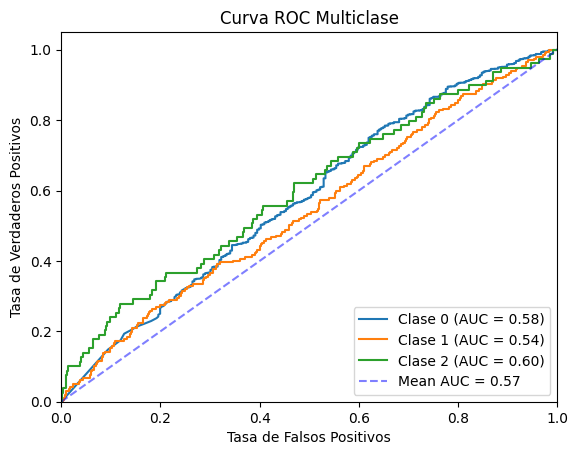

In [15]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar las curvas ROC
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Extraer los valores
values = roc_auc.values()
# Calcular la media
mean_auc = sum(values) / len(values)

plt.plot([0, 1], [0, 1], 'b--', label=f"Mean AUC = {mean_auc:.2f}", alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()